# Testing our three models

## Imports

In [1]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import timedelta
import plotly.express as px
from IPython.display import display
from sklearn.linear_model import LinearRegression
from collections.abc import Callable
from prophet import Prophet
import xgboost as xgb

In [2]:
#############
# Needed to suppress prophet output
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)
#############

## Fetching data

In [3]:
df = pd.read_csv("../consumption_temp.csv")
# Convert dftypes
df["time"] = pd.to_datetime(df["time"])
df["consumption"] = pd.to_numeric(df["consumption"])
df["temperature"] = pd.to_numeric(df["temperature"])

## Time-series split cross validation evaluation criteria

In [4]:

def time_series_split_validation(df, model_callback: Callable[[pd.DataFrame, pd.DataFrame], pd.DataFrame]):
    print("Evaluating", model_callback.__name__)

    df = df.copy()

    ret = pd.DataFrame()

    num_days = 30

    for loc in df.location.unique():
        print("Evaluating location", loc)
        tdf = df[df.location == loc][:-22] # needs to eliminate the last day with only 22 hrs to get full day tests
        tscv = TimeSeriesSplit(n_splits=num_days, gap=14, test_size=24) # gap=14 eliminates hours 10-23 of day before forecast

        counter = 1
        print("Forecast progress", end="")
        for split_tuple in tscv.split(tdf):
            print(" " + str(counter), end="")
            counter+=1

            fcst = model_callback(tdf.iloc[split_tuple[0]], tdf.iloc[split_tuple[1]])
            
            mape = (abs(fcst.consumption - fcst.yhat) / fcst.consumption).mean() * 100
            mae = (abs(fcst.consumption - fcst.yhat)).mean()
            
            fcst_date = fcst.time.dt.date.iloc[0]

            ret = pd.concat([ret, pd.DataFrame(data={'location': loc, 'forecast_date': fcst_date, 'mape': mape, 'mae': mae}, index=[0])])
        print()

    return ret.reset_index(drop=True)
            
            

## Model format

In [5]:
# all models will be in the following format
def naive_model(df, future):
    """ df and future already filtered by location """
    df = df.copy()
    future = future.copy()
    
    mean = df.consumption.mean()
    future['yhat'] = mean

    return future

In [6]:
for loc in df.location.unique():
    filtered_df = df[df.location == loc]
    fcst = naive_model(filtered_df.iloc[:-24], filtered_df.iloc[-24:])
    # display(fcst)
    # print(fcst.time.dt.date.iloc[0])

## Linear regression

In [7]:

def linear_model(df, future):
    df = df.copy()
    future = future.copy()
    
    model = LinearRegression()

    # Fit the model to the training data
    model.fit(df.temperature.values.reshape(-1, 1), df.consumption.values.reshape(-1, 1))

    # Make predictions on the test data
    y_pred = model.predict(future.temperature.values.reshape(-1, 1))
    future['yhat'] = y_pred

    return future

## Prophet

In [8]:

def prophet_model(df, future):
    df = df.copy()
    future = future.copy()
    
    model = Prophet()
    model.add_regressor('temperature')
    model.fit(df.rename(columns={'time': 'ds', 'consumption': 'y'}))

    # Make predictions on the test data
    y_pred = model.predict(future.rename(columns={'time': 'ds'})).yhat.values
    future['yhat'] = y_pred

    return future

## XGBoost

In [9]:

def xgboost_model(df, future):
    df = df.copy()
    future = future.copy()

    # creating time series features (chatgpt suggestions)
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['hour'] = df['time'].dt.hour
    df['day_of_week'] = df['time'].dt.dayofweek
    df['day_of_year'] = df['time'].dt.dayofyear
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    future['year'] = future['time'].dt.year
    future['month'] = future['time'].dt.month
    future['day'] = future['time'].dt.day
    future['hour'] = future['time'].dt.hour
    future['day_of_week'] = future['time'].dt.dayofweek
    future['day_of_year'] = future['time'].dt.dayofyear
    future['hour_sin'] = np.sin(2 * np.pi * future['hour'] / 24)
    future['hour_cos'] = np.cos(2 * np.pi * future['hour'] / 24)

    # Create and train an XGBoost model
    # Standard hyperparameters for prototyping, no gridsearch or similar
    model = xgb.XGBRegressor(
        n_estimators=1000,
        max_depth=5,
        learning_rate=0.1,
        objective="reg:absoluteerror", #"reg:squarederror",
        random_state=42,
    )
    X = df[['temperature', 'year', 'month', 'day', 'hour', 'day_of_week', 'day_of_year', 'hour_sin', 'hour_cos']]
    y = df['consumption']
    model.fit(X, y)

    # Make predictions on the test set
    X_test = future[['temperature', 'year', 'month', 'day', 'hour', 'day_of_week', 'day_of_year', 'hour_sin', 'hour_cos']]
    y_pred = model.predict(X_test)

    future['yhat'] = y_pred

    return future[['time', 'location', 'consumption', 'temperature', 'yhat']]



## Evaluation

In [10]:
out = pd.DataFrame()

for model_callback in [naive_model, linear_model, prophet_model, xgboost_model]:
    model_name = model_callback.__name__
    ret = time_series_split_validation(df, model_callback)[['location', 'mae']]
    ret = ret.groupby('location').mean().reset_index()
    ret['model'] = model_name
    out = pd.concat([out, ret[['location', 'model', 'mae']]])


Evaluating naive_model
Evaluating location bergen
Forecast progress 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
Evaluating location oslo
Forecast progress 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
Evaluating location stavanger
Forecast progress 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
Evaluating location tromsø
Forecast progress 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
Evaluating location trondheim
Forecast progress 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
Evaluating location helsingfors
Forecast progress 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
Evaluating linear_model
Evaluating location bergen
Forecast progress 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
Evaluating location oslo
Forecast progress 1 2 3 4 5 6 7 8 9 1

In [ ]:
outcpy = out.copy()
outcpy.sort_values('mae', ascending=False, inplace=True)

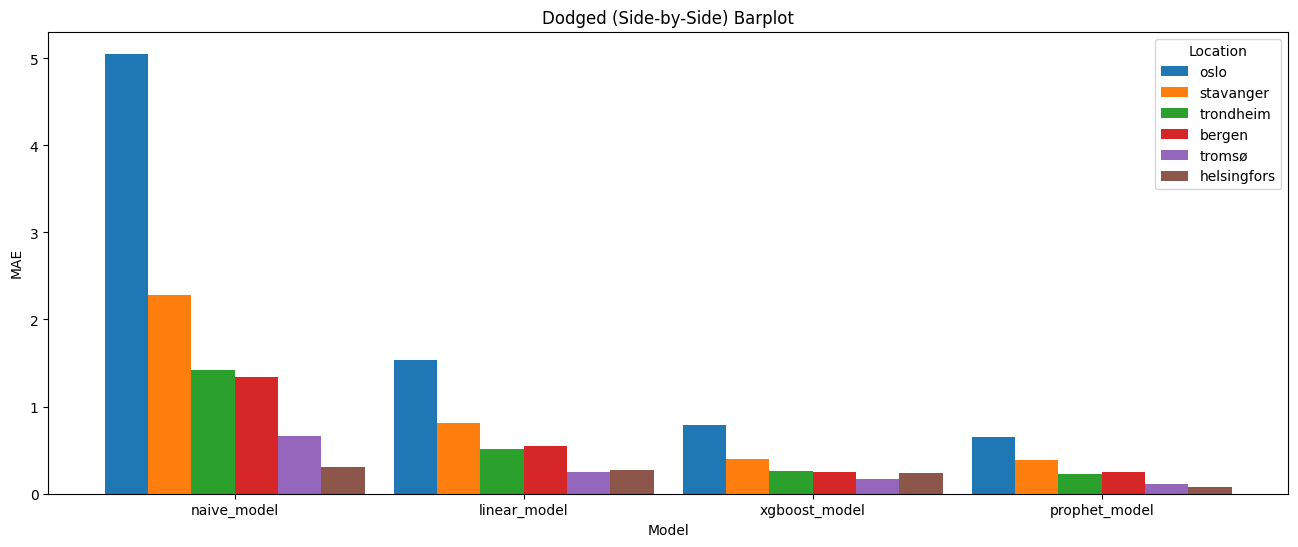

In [23]:
# Get unique models and locations
models = outcpy['model'].unique()
locations = outcpy['location'].unique()

# Create a dodged (side-by-side) bar plot
fig, ax = plt.subplots(figsize=(16, 6))

bar_width = 0.15
bar_positions = range(len(models))

for i, location in enumerate(locations):
    location_data = outcpy[outcpy['location'] == location]
    x_values = [pos + i * bar_width for pos in bar_positions]
    y_values = location_data['mae']
    
    ax.bar(x_values, y_values, width=bar_width, label=location)

ax.set_xticks([pos + (bar_width * (len(locations) - 1) / 2) for pos in bar_positions])
ax.set_xticklabels(models)
ax.set_xlabel('Model')
ax.set_ylabel('MAE')
ax.set_title('Dodged (Side-by-Side) Barplot')
plt.legend(title='Location')

plt.show()

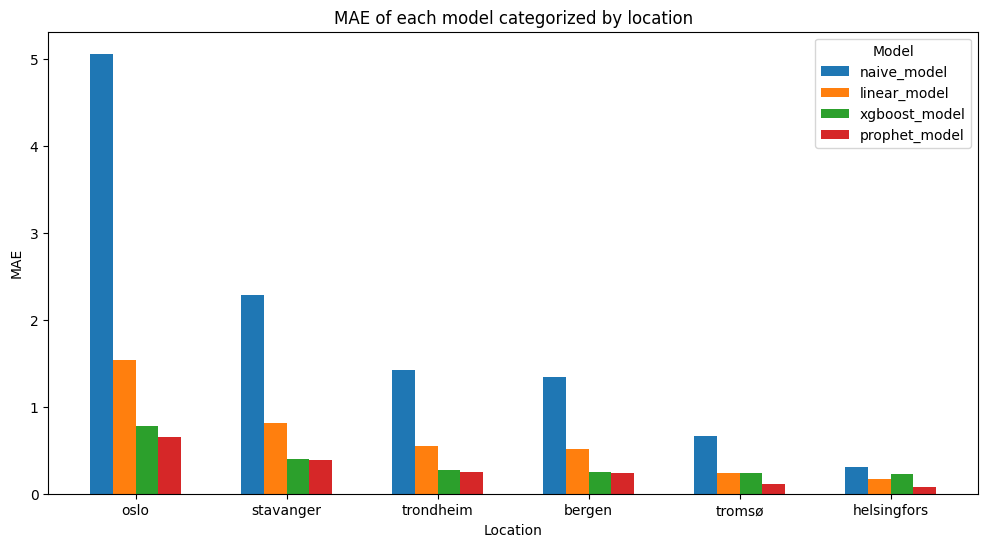

In [26]:
# Get unique models and locations
models = outcpy['model'].unique()
locations = outcpy['location'].unique()

# Create a dodged (side-by-side) bar plot with 'model' and 'location' switched
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.15
bar_positions = range(len(locations))

for i, model in enumerate(models):
    model_data = outcpy[outcpy['model'] == model]
    x_values = [pos + i * bar_width for pos in bar_positions]
    y_values = model_data['mae']
    
    ax.bar(x_values, y_values, width=bar_width, label=model)

ax.set_xticks([pos + (bar_width * (len(models) - 1) / 2) for pos in bar_positions])
ax.set_xticklabels(locations)
ax.set_xlabel('Location')
ax.set_ylabel('MAE')
ax.set_title('MAE of each model categorized by location')
plt.legend(title='Model')

plt.show()